In [1]:
from datavyz import graph_env # my custom dataviz environment
import numpy as np
from neural_network_dynamics import main as ntwk
#ge = graph_env('screen') # initialize a visualization env optimize for notebook display
import time

In [2]:
from model import Model
from iterative_random_search import InterativeSearch
search = InterativeSearch(Model,previous_batch_folder='batch1',run=False)
search.load_results()

In [53]:

from model import Model, REC_POPS, AFF_POPS

def get_x_best_configs(self, x):
    indices = np.argsort(self.result['residuals'])[::-1][:int(x)]
    return [self.result['configs'][i] for i in indices]

def reshape_SynapseMatrix_into_connectivity_proba(self, Matrix, Model, REC_POPS, AFF_POPS):


    for i, source_pop in enumerate(REC_POPS+AFF_POPS):
        for j, target_pop in enumerate(REC_POPS+AFF_POPS):
        Model['p_%s_%s' % (source_pop, target_pop)] = Matrix[i,:]/Model['N_%s' % source_pop]
    return pconnMatrix    
    

def reshape_SynapseMatrix_into_ConnecMatrix(self, Matrix, Model, REC_POPS, AFF_POPS):
    """
    uses the population number from "Model" to translate into connectivity
    """
    pconnMatrix = 0*Matrix
    for i, pop in enumerate(REC_POPS+AFF_POPS):
        N = Model['N_%s' % pop]
        pconnMatrix[i,:] = Matrix[i,:]/N
    return pconnMatrix    
    


[array([[11.41607404, 37.99209881, 17.81206478, 23.09401489],
        [35.26820791,  6.51059701, 25.1128924 ,  1.87938481],
        [ 9.33115837, 39.98521466, 23.42773647,  8.02289165],
        [36.06852688, 38.49877004, 32.16900562, 22.10219421],
        [35.35806699, 30.85303111,  4.27299361,  6.63015155],
        [37.18306822, 20.65104158,  4.36840409,  4.47207971]]),
 array([[33.14656277, 16.18368525, 26.57648821, 27.87860934],
        [36.0640071 , 21.83449425, 21.17960379,  9.33411626],
        [10.02747395,  1.70097996,  5.09670895,  3.04256859],
        [ 1.17760688, 39.77212018, 15.54263918, 15.98064461],
        [11.72117682, 32.50698135, 32.55824313, 16.30084056],
        [13.83254935, 39.69289846,  6.29802969, 35.80491458]]),
 array([[ 656.94799808, 1423.99995673,  580.56147439,  791.96352527],
        [  23.43836433,   55.78390837,   43.00320209,   74.46930746],
        [ 141.0052613 ,  274.56496659,    3.81092196,    5.01337871],
        [  35.27195353,   36.76241784,    

In [4]:
len(search.result['configs']), len(search.result['residuals']), search.result['Ntot']

(135202, 135202, 1871000)

In [3]:
from model import *

In [4]:
ge = graph_env('dark_notebook') # initialize a visualization env optimize for notebook display

In [6]:
Matrix = search.result['configs'][np.argmin(search.result['residuals'])]

In [7]:
from model import *
pconnMatrix = 0*Matrix
for i, poop in enumerate(REC_POPS+AFF_POPS):
    N = Model['N_%s' % pop]
    pconnMatrix[i,:] = Matrix[i,:]/N
pconnMatrix    

array([[0.02287013, 0.02101956, 0.03331021, 0.01544278],
       [0.01188646, 0.01670809, 0.01671686, 0.02243697],
       [0.00385558, 0.05483322, 0.05140166, 0.06471772],
       [0.0053527 , 0.05481065, 0.06950568, 0.0040579 ],
       [0.02683395, 0.01094194, 0.01627584, 0.02951907],
       [0.00363265, 0.05394331, 0.0760126 , 0.06583495]])

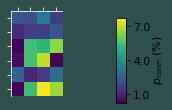

In [50]:
fig, ax, acb = ge.figure(figsize=(1.,1.), with_bar_legend=True, bottom=0.1)
Lims = [np.round(100*pconnMatrix.min(),1)-.1,np.round(100*pconnMatrix.max(),1)+.1]
ge.matrix(100*pconnMatrix.T, origin='upper', ax=ax, vmin=Lims[0], vmax=Lims[1])
ge.build_bar_legend_continuous(acb, ge.viridis, bounds=[Lims[0], Lims[1]],
                               label='$p_{conn}$ (%)')
ge.set_plot(ax,
            ['left', 'top'],
            tck_outward=0,
            xticks=.75*np.arange(0,4)+.75/2.,
            xticks_labels=[],
            xlim_enhancment=0, ylim_enhancment=0,
            yticks=.83*np.arange(0,6)+.85/2.,
            yticks_labels=[])
fig.savefig('fig.png')

TypeError: figure() got an unexpected keyword argument 'with_space_for_bar_legend'

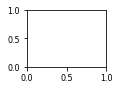

TypeError: figure() got an unexpected keyword argument 'with_space_for_bar_legend'

In [33]:


def connectivity_matrix_plot(Matrix, REC_POPS, AFF_POPS,
                             ax=None, graph=ge):
    if ax is None:
        fig, ax = graph.figure(left=.7, bottom=.7)
    else:
        fig = None

    ge.matrix(Matrix)

connectivity_matrix_plot(MinexcMatrix, REC_POPS, AFF_POPS)

(<Figure size 1542.05x260.787 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f782f3e2e10>)

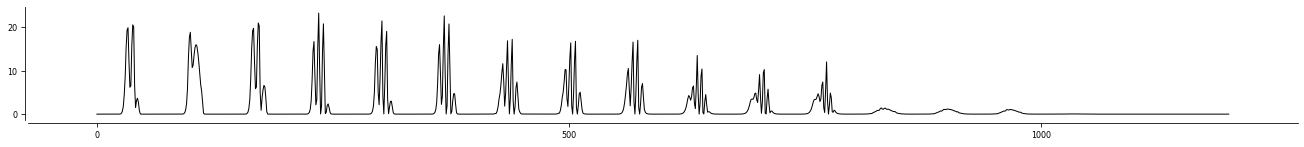

In [28]:

MinexcMatrix = search.result['configs'][np.argmin(search.result['residuals'])]
X = searchR.mf.run_single_connectivity_sim(MinexcMatrix, verbose=False)
ge.plot(X[1,:], fig_args={'figsize':(4,2)})

(<Figure size 147.402x130.394 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7831803d50>)

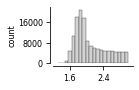

In [6]:
ge.hist(np.log10(search.result['residuals']))

In [7]:
search.mf.mean_Vm_func([0., 0., 200])

array([-0.05])

In [22]:
Cexc, Cinh = search.mf.compute_exc_inh_matrices(search.mf.ecMatrix)
X = search.mf.run_single_connectivity_sim(search.mf.ecMatrix, verbose=False)
print(np.dot(np.concatenate([X[:,0], search.mf.FAFF[:,int(0/search.mf.dt)]]), Cexc))

AttributeError: 'InterativeSearch' object has no attribute 'mf'

AttributeError: 'InterativeSearch' object has no attribute 'mf'

AttributeError: 'InterativeSearch' object has no attribute 'mf'

In [22]:
it, tt=1, 1
ipop = 3
search.mf.mean_Vm_func(np.array([np.dot(np.concatenate([X[:,it], search.mf.FAFF[:,int(tt/search.mf.dt)]]), Cexc)[ipop],
                                 np.dot(np.concatenate([X[:,it], search.mf.FAFF[:,int(tt/search.mf.dt)]]), Cinh)[ipop],
                                 search.mf.I_INTRINSINC[ipop,int(tt/search.mf.dt)]])[0])


array([-0.0671014])

In [37]:
CONFIGS = search.sort_random_configs()
X = search.mf.run_single_connectivity_sim(CONFIGS[4], verbose=False)
Vm = search.mf.convert_to_mean_Vm_trace(X, 'pyrExc')

WARNING    /home/yann/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:2514: RuntimeWarning: overflow encountered in multiply
  weight *= np.where(ei == i, 1 - yi, yi)
 [py.warnings]
WARNING    /home/yann/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:2514: RuntimeWarning: invalid value encountered in multiply
  weight *= np.where(ei == i, 1 - yi, yi)
 [py.warnings]
WARNING    /home/yann/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:2515: RuntimeWarning: invalid value encountered in add
  values += np.asarray(self.values[edge_indices]) * weight[vslice]
 [py.warnings]
WARNING    /home/yann/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:2539: RuntimeWarning: invalid value encountered in less
  out_of_bounds += x < grid[0]
 [py.warnings]
WARNING    /home/yann/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:2540: RuntimeWarning: invalid value encountered in greater
  out_of

In [54]:
CONFIGS[0] = search.mf.ecMatrix
X = search.mf.run_single_connectivity_sim(CONFIGS[4], verbose=False)
Vm = search.mf.convert_to_mean_Vm_trace(X, 'pyrExc')
cond = (Vm>-100e-3) & (Vm<=-30e-3)
residual = np.sqrt(np.sum((1e3*Vm-Model['pyrExc_El']-search.desired_Vm)**2))
np.isfinite(residual)

WARNING    /home/yann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
 [py.warnings]
WARNING    /home/yann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.
 [py.warnings]
WARNING    /home/yann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in square
  """
 [py.warnings]


False

In [59]:
res = search.run_single_sim(CONFIGS[4])

WARNING    /home/yann/work/spkNtwk-cortStatesWakefulness/iterative_random_search.py:89: RuntimeWarning: invalid value encountered in greater
  residual = np.sqrt(np.sum((1e3*Vm-self.Model['pyrExc_El']-self.desired_Vm)**2))
 [py.warnings]
WARNING    /home/yann/work/spkNtwk-cortStatesWakefulness/iterative_random_search.py:89: RuntimeWarning: invalid value encountered in less_equal
  residual = np.sqrt(np.sum((1e3*Vm-self.Model['pyrExc_El']-self.desired_Vm)**2))
 [py.warnings]


613 1200


[-69.72111618 -69.72111618 -69.72111618 ...          nan          nan
          nan]


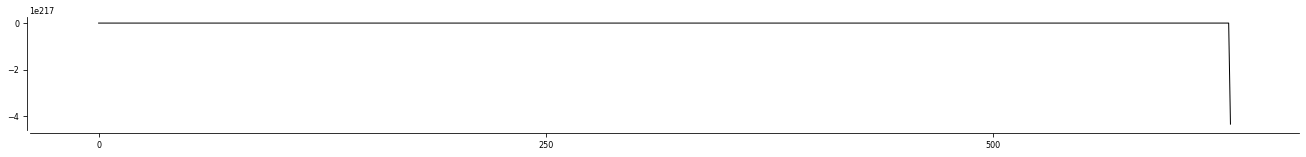

In [39]:
ge.plot(1e3*Vm, fig_args={'figsize':(4,2)})
print(1e3*Vm)

In [19]:
from model import Model
from iterative_random_search import InterativeSearch
searchR = InterativeSearch(Model, run=True)


Adding Increasing Step Waveform to: AffExc
Setting Constant Level to: NoiseExc
Adding intrinsic oscillation to: oscillExc
Initializing simulation [...]
Performing grid simulation [...]


Building interpolation [...]
--> Done !


In [ ]:

searchR.mf.run_single_connectivity_sim(search.mf.ecMatrix, verbose=False)

In [3]:
from model import Model, REC_POPS, AFF_POPS
import neural_network_dynamics.main as ntwk
from Umodel import Umodel

mf = ntwk.FastMeanField(Model, REC_POPS, AFF_POPS, tstop=6.)

mf.build_TF_func(100, with_Vm_functions=True, sampling='log')


Adding Increasing Step Waveform to: AffExc
Setting Constant Level to: NoiseExc
Adding intrinsic oscillation to: oscillExc
Initializing simulation [...]
Performing grid simulation [...]
Building interpolation [...]
--> Done !
running ODE integration [...]
--- ODE integration took 236.9 milliseconds 


In [29]:
Vm0 = search.desired_Vm
1e-3*Vm0-70e-3

array([-0.06986524, -0.06983196, -0.0697324 , ..., -0.04999962,
       -0.04999983, -0.04999996])

WARNING    /home/yann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
 [py.warnings]
WARNING    /home/yann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less_equal
  This is separate from the ipykernel package so we can avoid doing imports until
 [py.warnings]
WARNING    /home/yann/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:2515: RuntimeWarning: overflow encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]
 [py.warnings]


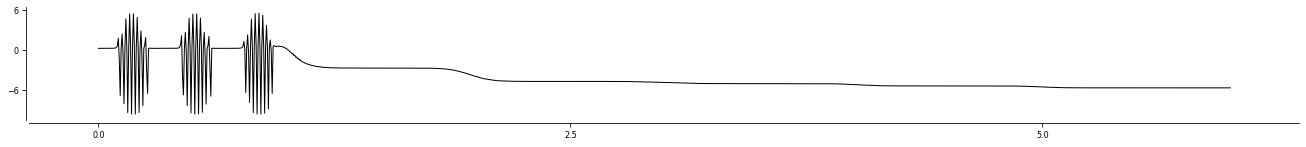

In [51]:
for i in range(1000):
    res = compute_Vm_residual(search, mf.run_single_connectivity_sim(CONFIGS[i,:,:], verbose=False))
    if res<100:
        X = mf.run_single_connectivity_sim(CONFIGS[i,:,:], verbose=False)
        Vm = mf.convert_to_mean_Vm_trace(X, 'pyrExc')
        ge.plot(mf.t, 1e3*Vm+70, fig_args={'figsize':(4,2)})
        

1200 1200


(<Figure size 147.402x130.394 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6ea53a2f50>)

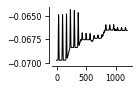

In [30]:
cond = (Vm>-80e-3) & (Vm<-50e-3)
print(len(cond), np.sum(cond))
clean_Vm = Vm[cond]
ge.plot(clean_Vm)

(<Figure size 147.402x130.394 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6ea5577b10>)

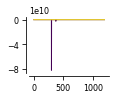

In [15]:
ge.plot(Y=[1e3*Vm-Model['pyrExc_El'],search.desired_Vm])

In [37]:
def compute_Vm_residual(self, X):
    Vm = self.mf.convert_to_mean_Vm_trace(X, 'pyrExc')
    cond = (Vm>-80e-3) & (Vm<=-45e-3)
    if np.sum(cond)<len(cond):
        return 1000
    else:
        residual = np.sqrt(np.sum((1e3*Vm-Model['pyrExc_El']-search.desired_Vm)**2))
        return residual/mf.t[-1]

compute_Vm_residual(search, X)

42.80145220313377

In [13]:
X = mf.run_single_connectivity_sim(CONFIGS[0,:,:], verbose=True)
Vm = mf.convert_to_mean_Vm_trace(X, 'pyrExc')
print(np.sum(np.sqrt((1e3*Vm-Model['pyrExc_El']-search.desired_Vm)**2)))

running ODE integration [...]
--- ODE integration took 267.9 milliseconds 
84446924323.403


In [50]:
CONFIGS = search.sort_random_configs(seed=1, n=1000)

In [6]:
CONFIGS[0,:,:]

array([[41.70220047, 41.91945144, 80.07445687,  9.83468338],
       [98.88610889,  1.93669579, 10.23344288, 90.34019153],
       [88.33060912, 11.4745973 , 32.66449018, 17.23405083],
       [ 1.98801338, 58.57592715, 55.6240234 ,  7.19742797],
       [23.98477591, 31.73624093, 62.9717507 , 26.32967705],
       [95.01761192, 39.48756129, 17.61962556, 45.98802658]])

1200 1200


NameError: name 'search' is not defined

In [5]:
from model import Model
from iterative_random_search import InterativeSearch
search = InterativeSearch(Model, run=True)


Adding Increasing Step Waveform to: AffExc
Setting Constant Level to: NoiseExc
Adding intrinsic oscillation to: oscillExc
Initializing simulation [...]
Performing grid simulation [...]
Building interpolation [...]
--> Done !


In [13]:
from neural_network_dynamics import main as ntwk
#import ntwk.stim_waveforms as stim_waveforms

In [50]:
from scipy.interpolate import RegularGridInterpolator
import itertools

from neural_network_dynamics import main as ntwk

class FastMeanField:

    def __init__(self, Model, REC_POPS, AFF_POPS,
                 tstop=None, dt=None):

        self.REC_POPS = REC_POPS
        self.AFF_POPS = AFF_POPS
        self.Model = Model
        
        # initialize time axis
        if dt is None:
            self.dt = Model['dt']
        else:
            self.dt = dt
        if tstop is None:
            self.tstop = Model['tstop']
        else:
            self.tstop = tstop
        self.t = np.arange(int(self.tstop/self.dt))*self.dt
        
        # initialize connectivity matrix
        self.initialize_Effective_Connectivity_Matrix(Model)
        self.compute_exc_inh_matrix_factors(Model)
        
        # initialize afferent input
        self.FAFF = np.zeros((len(self.t),len(self.AFF_POPS)))
        for ipop, pop in enumerate(AFF_POPS):
            if '%s_IncreasingStep_size'%pop in Model:
                print('Adding Increasing Step Waveform to:', pop)
                self.FAFF[:,ipop] = ntwk.stim_waveforms.IncreasingSteps(self.t, pop, Model, translate_to_SI=True)
            else:
                print('Setting Constant Level to:', pop)
                self.FAFF[:,ipop] = 0*self.t+Model['F_%s'%pop]

        # intrinsic currents
        self.I_INTRINSINC = np.zeros((len(self.t),len(self.REC_POPS)))
        for ipop, pop in enumerate(REC_POPS):
            # only support for time-phase-locked oscillatory current so far
            if '%s_Ioscill_freq'%pop in Model:
                print('Adding intrinsic oscillation to:', pop)
                self.I_INTRINSINC[:,ipop] = ntwk.stim_waveforms.Intrinsic_Oscill(self.t, pop, Model, translate_to_SI=True)

        # matrix
        self.compute_exc_inh_matrix_factors(Model)

        self.TF_func = None # to be initialized !
        
    # initialize Effective Connectivity
    def initialize_Effective_Connectivity_Matrix(self, Model):
        self.ecMatrix = np.zeros((len(self.REC_POPS)+len(self.AFF_POPS), len(self.REC_POPS)))
        for i, ii in enumerate(self.REC_POPS+self.AFF_POPS):
            for j, jj in enumerate(self.REC_POPS):
                self.ecMatrix[i,j] = Model['p_%s_%s' % (ii,jj)]*Model['N_%s' % ii]


    def compute_exc_inh_matrix_factors(self, Model):
        self.CexcF = np.zeros((len(self.REC_POPS)+len(self.AFF_POPS), len(self.REC_POPS)))
        self.CinhF = np.zeros((len(self.REC_POPS)+len(self.AFF_POPS), len(self.REC_POPS)))
        for i, ii in enumerate(self.REC_POPS+self.AFF_POPS):
            for j, jj in enumerate(self.REC_POPS):
                if len(ii.split('Exc'))>1:
                    self.CexcF[i,j] = 1.
                elif len(ii.split('Inh'))>1:
                    self.CinhF[i,j] = 1.
                else:
                    raise NameError('/!\ %s is not classified as Exc or Inh' % ii+jj)

                
    def compute_exc_inh_matrices(self, ecMatrix):
        # just separates excitation and inhibition
        return np.multiply(ecMatrix, sim.CexcF), np.multiply(ecMatrix, sim.CinhF)

    
    def build_TF_func(self, Ngrid=20, coeffs_location='data/COEFFS_pyrExc.npy', pop=None):
        """
        """

        print('Initializing simulation [...]')
        if pop is None:
            pop = self.REC_POPS[0]
            
        # taking just one Exc and One Inh pop for the scan !!
        Exc_pop = [rec for rec in REC_POPS if len(rec.split('Exc'))>1][0]
        Inh_pop = [rec for rec in REC_POPS if len(rec.split('Inh'))>1][0]
        
        # building artificial simulation situation (with just one exc and one inh)
        AFF_POPS = [Exc_pop, Inh_pop]
        Model2 = self.Model.copy()
        Model2['N_%s'%Exc_pop], Model2['N_%s'%Inh_pop] = 10, 10
        Model2['p_%s_%s'%(Exc_pop, pop)], Model2['p_%s_%s'%(Inh_pop, pop)] = 0.1, 0.1
        
        nrn_params = ntwk.built_up_neuron_params(Model2, pop)
        syn_input = ntwk.build_up_afferent_synaptic_input(Model2,
                                                          AFF_POPS, pop)
        Model2['COEFFS'] = np.load(coeffs_location)
        Freq_Exc = np.logspace(-2, 3, Ngrid+1)
        Freq_Inh = np.logspace(-2, 3, Ngrid)
        Ioscill = np.linspace(0, 20*10, int(Ngrid/2))
        output_freq = np.zeros((len(Freq_Exc), len(Freq_Inh), len(Ioscill)))

        print('Performing grid simulation [...]')
        for i, j, k in itertools.product(range(len(Freq_Exc)), range(len(Freq_Inh)),
                                         range(len(Ioscill))):
            if Freq_Exc[i]<10:
                output_freq[i,j,k] = 0
            else:
                output_freq[i,j,k] = ntwk.mean_field.input_output(nrn_params, syn_input,
                                        {'F_%s'%Exc_pop:Freq_Exc[i], 'F_%s'%Inh_pop:Freq_Inh[j]},
                                        Model2['COEFFS'],
                                        current_input=Ioscill[k])
        print('Building interpolation [...]')
        self.TF_func = RegularGridInterpolator([Freq_Exc*\
                                                Model2['p_%s_%s'%(Exc_pop, pop)]*Model2['N_%s'%Exc_pop],
                                                Freq_Inh*\
                                                Model2['p_%s_%s'%(Inh_pop, pop)]*Model2['N_%s'%Inh_pop],
                                                Ioscill],
                                               output_freq,
                                               method='linear',
                                               fill_value=None, bounds_error=False)
        print('--> Done !')

    def rise_factor(self, X, t, Cexc, Cinh):
        return self.TF_func(np.array([np.dot(np.concatenate([X, self.FAFF[int(t/self.dt),:]]), Cexc),
                              np.dot(np.concatenate([X, self.FAFF[int(t/self.dt),:]]), Cinh),
                              self.I_INTRINSINC[int(t/self.dt),:]]).T)

    
    def dX_dt(self, X, t, Cexc, Cinh, tau=5e-3):
        return (self.rise_factor(X,t,Cexc,Cinh)-X)/tau

        
    def run_single_connectivity_sim(self, ecMatrix):
        
        X = np.zeros((len(self.t), len(self.REC_POPS)))
        
        if self.TF_func is None:
            raise NameError('/!\ Need to run the "build_TF_func" protocol before')
        else:
            Cexc, Cinh = self.compute_exc_inh_matrices(ecMatrix)
            # simple forward Euler iteration
            for it, tt in enumerate(self.t[:-1]):
                X[it+1,:] = X[it,:]+self.dt*self.dX_dt(X[it,:], tt, Cexc, Cinh)
                
        return X



In [53]:
sim.build_TF_func(40)

Initializing simulation [...]
Performing grid simulation [...]
Building interpolation [...]
--> Done !


In [54]:
X = sim.run_single_connectivity_sim(sim.ecMatrix)

(<Figure size 1542.05x391.181 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5330320a10>)

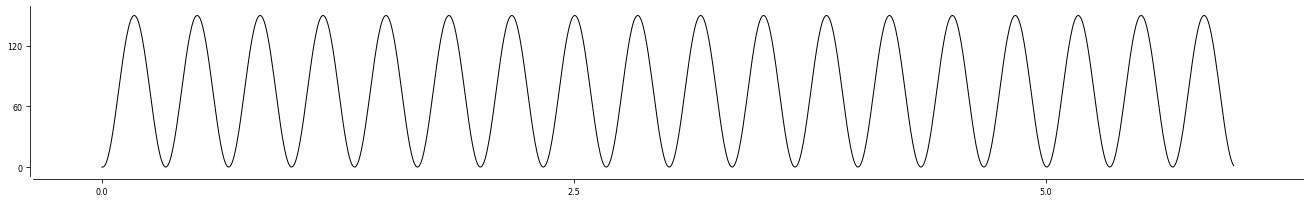

In [55]:
ge.plot(sim.t, sim.I_INTRINSINC[:,1], fig_args=dict(figsize=(4,3)))

(<Figure size 1542.05x391.181 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f53302c5790>)

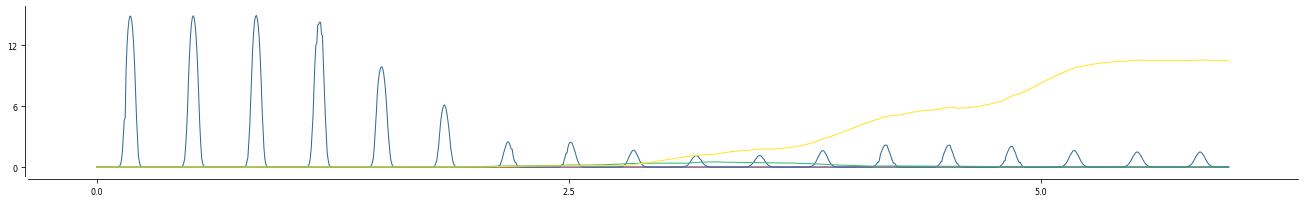

In [56]:
ge.plot(sim.t, Y=X.T, fig_args=dict(figsize=(4,3)))

In [36]:
from model import Model, REC_POPS, AFF_POPS


In [51]:
sim = FastMeanField(Model, REC_POPS, AFF_POPS, tstop=6, dt=5e-3)

Adding Increasing Step Waveform to: AffExc
Setting Constant Level to: NoiseExc
Adding intrinsic oscillation to: oscillExc


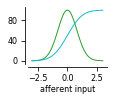

In [5]:
from analyz.signal_library.classical_functions import gaussian, gaussian_cumproba
x = np.linspace(-3,3)
fig, ax = ge.figure(with_legend_space=True)
ge.plot(x, 100.*gaussian(x, std=0.8)/np.max(gaussian(x, std=0.8)), ax=ax, no_set=True, color=ge.g)
ge.plot(x, 100.*gaussian_cumproba(x), ax=ax, no_set=True, color=ge.cyan)
ge.set_plot(ax, xlabel='afferent input', ylabel='')

# Transfer function determnination

In [3]:
data = np.load('data/tf_data.npy', allow_pickle=True).item()

In [182]:

from model import *

# generate the function
data = np.load('data/tf_data.npy', allow_pickle=True).item()
data['Model']['COEFFS'] = np.load('data/COEFFS_pyrExc.npy')

# scanning grid !
N = 50
Ioscill = np.linspace(0, 20*10, N-1)
Freq_Exc = np.logspace(np.log10(0.1), np.log10(1000), N+1)*\
    data['Model']['N_pyrExc']*data['Model']['p_pyrExc_pyrExc']
Freq_Inh = np.logspace(np.log10(0.1), np.log10(1000), N)*\
    data['Model']['N_recInh']*data['Model']['p_recInh_pyrExc']


# ten we put evrything to 1 to absorb all constants
data['Model']['N_pyrExc'], data['Model']['p_pyrExc_pyrExc'] = 1, 1
data['Model']['N_recInh'], data['Model']['p_recInh_pyrExc'] = 1, 1
nrn_params = ntwk.built_up_neuron_params(data['Model'], 'pyrExc')
syn_input = ntwk.build_up_afferent_synaptic_input(data['Model'],
                                                  ['pyrExc', 'recInh'], 'pyrExc')

import itertools

points, output_freq = [], []
output_freq = np.zeros((len(Freq_Exc), len(Freq_Inh), len(Ioscill)))
for i, j, k in itertools.product(range(len(Freq_Exc)), range(len(Freq_Inh)), range(len(Ioscill))):
    points.append([Freq_Exc[i], Freq_Inh[j], Ioscill[k]])
    output_freq[i,j,k] = ntwk.mean_field.input_output(nrn_params, syn_input,
                                                    {'F_pyrExc':Freq_Exc[i], 'F_recInh':Freq_Inh[j]},
                                                    data['Model']['COEFFS'],
                                                    current_input=Ioscill[k])
points = np.array(points)

output_freq = np.array(output_freq)

# firing_lower_threshold = 1e-2
#output_freq[output_freq<firing_lower_threshold] = firing_lower_threshold

In [183]:
from scipy.interpolate import RegularGridInterpolator
func = RegularGridInterpolator([Freq_Exc, Freq_Inh, Ioscill],
                               output_freq,
                               method='linear',
                               fill_value=None, bounds_error=False)

In [254]:
nrn_params = ntwk.built_up_neuron_params(Model, 'oscillExc')
syn_input = ntwk.build_up_afferent_synaptic_input(Model,
                                                  ['oscillExc', 'recInh', 'AffExc'], 'oscillExc')
Model['COEFFS'] = np.load('data/COEFFS_pyrExc.npy')
print(ntwk.mean_field.input_output(nrn_params, syn_input,
                                   {'F_oscillExc': 0.1, 'F_recInh': 0.1, 'F_AffExc': 2.0},
                                   Model['COEFFS'],
                                   current_input=0))
print(func([20., 0., 0.]))

2.6005583810190283
[6.80471688e-18]


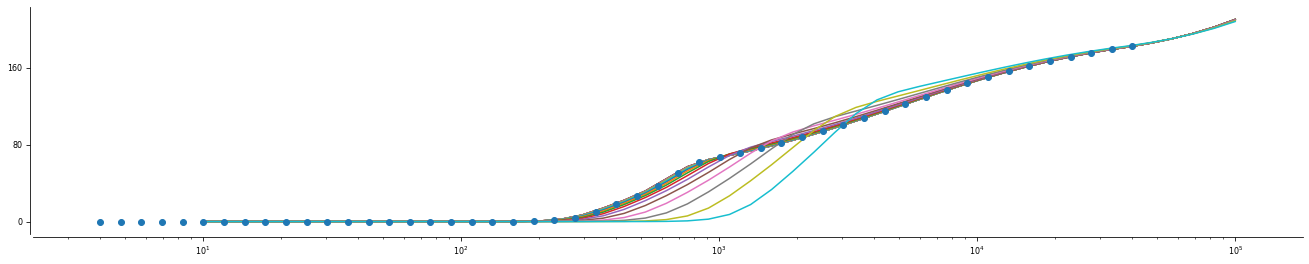

In [84]:
fig, ax = ge.figure(figsize=(4,4))
freq = np.logspace(1, 5)
for i, fi in enumerate(np.logspace(np.log10(0.1), np.log10(500), 20)):
    ax.plot(freq, func([[f, fi, 0] for f in freq]))

ax.plot(Freq_Exc, output_freq[:,0,0], 'o')
#ge.set_plot(ax, xscale='log', yscale='log')
ge.set_plot(ax, xscale='log')

In [7]:
%time x=[func([i, 200, 0.1]) for i in range(200)]        

CPU times: user 69.7 ms, sys: 8.62 ms, total: 78.3 ms
Wall time: 62.2 ms


In [34]:
# designing the 

#tstop, dt = 1e-3*data['tstop'], 1e-2
#t = np.arange(int(tstop/dt))*dt


# F array in to order of REC_POPS
F = np.ones(len(REC_POPS))
A = np.ones(len(AFF_POPS))

Connectivity_Matrix = None
# Connectivity matrix of size (a+f, f)
C = np.zeros((len(REC_POPS)+len(AFF_POPS), len(REC_POPS)))
# connectivity matrix of excitatory interactions
Cexc = np.zeros((len(REC_POPS)+len(AFF_POPS), len(REC_POPS)))
# connectivity matrix of excitatory interactions
Cinh = np.zeros((len(REC_POPS)+len(AFF_POPS), len(REC_POPS)))
# building the connectivities for the ODE solver
for i, ii in enumerate(REC_POPS+AFF_POPS):
    for j, jj in enumerate(REC_POPS):
        if Connectivity_Matrix is None:
            C[i,j] = Model['p_%s_%s' % (ii,jj)]*Model['N_%s' % ii]
        else:
            C[i,j] = Connectivity_Matrix[i,j]
        if len(ii.split('Exc'))>1:
            Cexc[i,j] = C[i,j]
        elif len(ii.split('Inh'))>1:
            Cinh[i,j] = C[i,j]
        else:
            print('/!\ %s is not classified as Exc or Inh' % ii+jj)

# building the input arrays
def func_Fafferent(tt):
    if tt>1:
        return np.array([1.,
                         1.])
    else:
        return np.array([1.,
                         1.])

# building the non-synaptic currents
def func_Iintrinsic(tt):
    if tt>40e-3:
        return np.array([0,
                         200,
                         0,
                         0])
    else:
        return np.zeros(4)

from scipy.integrate import odeint

def growth_factor(X, t):
    
    Fexc_over_pops = np.dot(np.concatenate([X, func_Fafferent(t)]),
                            Cexc)
    Finh_over_pops = np.dot(np.concatenate([X,func_Fafferent(t)]),
                            Cinh)

    return np.array([func([Fexc_over_pops[i],
                           Finh_over_pops[i],
                           func_Iintrinsic(t)[i]])[0] for i in range(len(REC_POPS))])
    
def dX_dt(X, t, tau=5e-3):
    
    return (growth_factor(X,t)-X)/tau
    
dt, tstop = 1e-4, 0.1
t = np.arange(int(tstop/dt))*dt
X0 = np.ones(len(REC_POPS))*1
X = odeint(dX_dt, X0, t)#, args=(func_Iintrinsic, func_Fafferent))

(None, <matplotlib.axes._subplots.AxesSubplot at 0x7efc646bff90>)

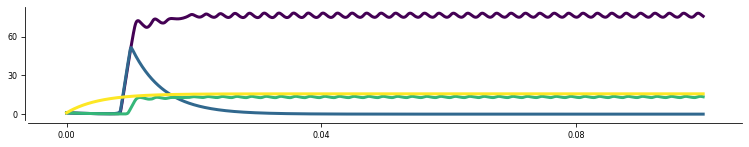

In [35]:
fig, ax=ge.figure(figsize=(3,2))
#ge.plot(t, Y=[Fmf['pyrExc']+1e-2, Fmf['oscillExc']+1e-2], ax=ax, COLORS=['k', ge.brown])
ge.plot(t, Y=X.T, ax=ax, lw=3)

[ 7927.55438942  8218.15566795 15921.10877883    72.        ]


(None, <matplotlib.axes._subplots.AxesSubplot at 0x7efc54e3da90>)

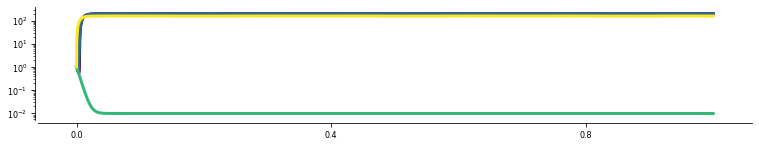

In [69]:
dt, tstop = 1e-4, 1.
t = np.arange(int(tstop/dt))*dt
Y = np.ones((len(t),len(REC_POPS)))*1

def Fexc_over_pops(X, t):
    return np.dot(np.concatenate([X, [3.,3.]]), Cexc)

def Finh_over_pops(X, t):
    return np.dot(np.concatenate([X, [3.,3.]]), Cinh)

def growth_factor(X, t):
    
    #Fexc_over_pops = np.dot(np.concatenate([X, func_Fafferent(t)]), Cexc)
    #Finh_over_pops = np.dot(np.concatenate([X,func_Fafferent(t)]), Cinh)
    
    return np.array([func([Fexc_over_pops(X,t)[i],
                           Finh_over_pops(X,t)[i],
                           100*(1-np.cos(2*np.pi*3*t))])[0] for i in range(len(REC_POPS))])


tau=5e-3
for it, tt in enumerate(t[1:]):
    Y[it+1,:] = Y[it,:]+dt*(growth_factor(Y[it,:],tt)-Y[it,:])/tau
    
print(Fexc_over_pops(Y[-1], t[-1]))
fig, ax=ge.figure(figsize=(3,2))
#ge.plot(t, Y=Y.T+1e-2, ax=ax, lw=3, axes_args=dict(yscale='log'))


In [70]:
Cexc

array([[40., 40., 80.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 5.,  0., 20., 20.],
       [ 4., 40., 20.,  4.]])

[ 28.2 132.  126.   73.2] [0. 0. 0. 0.]


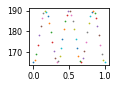

In [542]:
X = [0, 0, 0, 0]
t=.3
Fexc_over_pops = np.dot(Cexc.T,
                            np.concatenate([X, func_Fafferent(t)]))
Finh_over_pops = np.dot(Cinh.T,
                            np.concatenate([X,func_Fafferent(t)]))

i=1
print(Fexc_over_pops, Finh_over_pops)
fig, ax = ge.figure()
for t in np.linspace(0,1):
    #ax.scatter([t], [func([Fexc_over_pops[i], Finh_over_pops[i], func_Iintrinsic(t)[i]])], s=0.5)
    ax.scatter([t], [func([160, 0, func_Iintrinsic(t)[i]])], s=0.5)


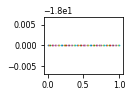

In [527]:
X = np.ones(4)*1e-1
i=1
fig, ax = ge.figure()
for t in np.linspace(0,1):
    ax.scatter([t], [dX_dt(X,t)[i]], s=0.5)

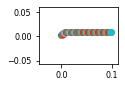

In [528]:
X = np.ones(4)*0

dt = 1e-3

fig, ax= ge.figure()
for it in range(100):
    X = X + dX_dt(X,it*dt)*dt
    ax.scatter([it*dt], [X[1]])
    #ax.scatter([it*dt], [dX_dt(X,float(it*dt))[1]])
                

(<Figure size 147.402x130.394 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7febdad6eb90>)

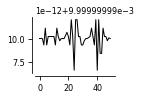

In [430]:
ge.plot([func([40, 0, func_Iintrinsic(tt)[1]]) for tt in np.linspace(0,1)])

(<Figure size 147.402x130.394 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7febdd9fc8d0>)

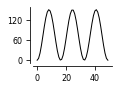

In [239]:
ge.plot([func_Iintrinsic(tt)[1] for tt in np.linspace(0,1)])

In [410]:
np.dot(np.concatenate([F,A]), Cexc)

array([ 49.,  81., 120.,  24.])

In [131]:
REC_POPS

['pyrExc', 'oscillExc', 'recInh', 'dsInh']

In [43]:
Cexc

array([[0.01, 0.01, 0.02, 0.  ],
       [0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.05, 0.  , 0.2 , 0.2 ],
       [0.02, 0.2 , 0.1 , 0.02]])

In [271]:
from scipy.interpolate import RegularGridInterpolator

def Intrinsic_Oscill(t, pop, Model):
    signal = 0*t
    cond = t>Model['%s_Ioscill_onset'%pop]
    signal[cond] = Model['%s_Ioscill_amp'%pop]*(1-np.cos(2.*np.pi*Model['%s_Ioscill_freq'%pop]*(t[cond]-t[cond][0])))/2.
    return signal

from analyz.processing.signanalysis import gaussian_smoothing
def IncreasingSteps(t, pop, Model):
    signal = 0*t+Model['%s_IncreasingStep_baseline'%pop]
    i, t0 = 1, Model['%s_IncreasingStep_t0'%pop]
    while t0<t[-1]:
        signal[t>t0] = Model['%s_IncreasingStep_baseline'%pop]+i*Model['%s_IncreasingStep_size'%pop]
        t0+=Model['%s_IncreasingStep_length'%pop]
        i+=1
    
    return gaussian_smoothing(signal, int(Model['%s_IncreasingStep_smoothing'%pop]/(t[1]-t[0])))
    
class FastMeanField:

    def __init__(self, Model, REC_POPS, AFF_POPS):

        self.REC_POPS = REC_POPS
        self.AFF_POPS = AFF_POPS
        self.Model = Model
        
        # initialize time axis
        self.dt = Model['dt']
        self.t = np.arange(int(Model['tstop']/self.dt))*self.dt
        
        # initialize connectivity matrix
        self.initialize_Effective_Connectivity_Matrix(Model)
        self.compute_exc_inh_matrix_factors(Model)
        
        # initialize afferent input
        self.FAFF = np.zeros((len(self.t),len(self.AFF_POPS)))
        for ipop, pop in enumerate(AFF_POPS):
            if '%s_IncreasingStep_size'%pop in Model:
                print('Adding Increasing Step Waveform to:', pop)
                self.FAFF[:,ipop] = IncreasingSteps(self.t, pop, Model)
            else:
                print('Setting Constant Level to:', pop)
                self.FAFF[:,ipop] = 0*self.t+Model['F_%s'%pop]

        # intrinsic currents
        self.I_INTRINSINC = np.zeros((len(self.t),len(self.REC_POPS)))
        for ipop, pop in enumerate(REC_POPS):
            # only support for time-phase-locked oscillatory current so far
            if '%s_Ioscill_freq'%pop in Model:
                print('Adding intrinsic oscillation to:', pop)
                self.I_INTRINSINC[:,ipop] = Intrinsic_Oscill(self.t, pop, Model)

        # matrix
        self.compute_exc_inh_matrix_factors(Model)

        self.TF_func = None # to be initialized !
        
    # initialize Effective Connectivity
    def initialize_Effective_Connectivity_Matrix(self, Model):
        self.ecMatrix = np.zeros((len(self.REC_POPS)+len(self.AFF_POPS), len(self.REC_POPS)))
        for i, ii in enumerate(self.REC_POPS+self.AFF_POPS):
            for j, jj in enumerate(self.REC_POPS):
                self.ecMatrix[i,j] = Model['p_%s_%s' % (ii,jj)]*Model['N_%s' % ii]


    def compute_exc_inh_matrix_factors(self, Model):
        self.CexcF = np.zeros((len(self.REC_POPS)+len(self.AFF_POPS), len(self.REC_POPS)))
        self.CinhF = np.zeros((len(self.REC_POPS)+len(self.AFF_POPS), len(self.REC_POPS)))
        for i, ii in enumerate(self.REC_POPS+self.AFF_POPS):
            for j, jj in enumerate(self.REC_POPS):
                if len(ii.split('Exc'))>1:
                    self.CexcF[i,j] = 1.
                elif len(ii.split('Inh'))>1:
                    self.CinhF[i,j] = 1.
                else:
                    raise NameError('/!\ %s is not classified as Exc or Inh' % ii+jj)

                
    def compute_exc_inh_matrices(self, ecMatrix):
        # just separates excitation and inhibition
        return np.multiply(ecMatrix, sim.CexcF), np.multiply(ecMatrix, sim.CinhF)

    
    def build_TF_func(self, Ngrid=20, coeffs_location='data/COEFFS_pyrExc.npy', pop=None):
        """
        """

        print('Initializing simulation [...]')
        if pop is None:
            pop = self.REC_POPS[0]
            
        # taking just one Exc and One Inh pop for the scan !!
        Exc_pop = [rec for rec in REC_POPS if len(rec.split('Exc'))>1][0]
        Inh_pop = [rec for rec in REC_POPS if len(rec.split('Inh'))>1][0]
        
        # building artificial simulation situation (with just one exc and one inh)
        AFF_POPS = [Exc_pop, Inh_pop]
        Model2 = self.Model.copy()
        Model2['N_%s'%Exc_pop], Model2['N_%s'%Inh_pop] = 10, 10
        Model2['p_%s_%s'%(Exc_pop, pop)], Model2['p_%s_%s'%(Inh_pop, pop)] = 0.1, 0.1
        
        nrn_params = ntwk.built_up_neuron_params(Model2, pop)
        syn_input = ntwk.build_up_afferent_synaptic_input(Model2,
                                                          AFF_POPS, pop)
        Model2['COEFFS'] = np.load(coeffs_location)
        Freq_Exc = np.logspace(-2, 3, Ngrid+1)
        Freq_Inh = np.logspace(-2, 3, Ngrid)
        Ioscill = np.linspace(0, 20*10, int(Ngrid/2))
        output_freq = np.zeros((len(Freq_Exc), len(Freq_Inh), len(Ioscill)))

        print('Performing grid simulation [...]')
        for i, j, k in itertools.product(range(len(Freq_Exc)), range(len(Freq_Inh)),
                                         range(len(Ioscill))):
            if Freq_Exc[i]<10:
                output_freq[i,j,k] = 0
            else:
                output_freq[i,j,k] = ntwk.mean_field.input_output(nrn_params, syn_input,
                                        {'F_%s'%Exc_pop:Freq_Exc[i], 'F_%s'%Inh_pop:Freq_Inh[j]},
                                        Model2['COEFFS'],
                                        current_input=Ioscill[k])
        print('Building interpolation [...]')
        self.TF_func = RegularGridInterpolator([Freq_Exc*\
                                                Model2['p_%s_%s'%(Exc_pop, pop)]*Model2['N_%s'%Exc_pop],
                                                Freq_Inh*\
                                                Model2['p_%s_%s'%(Inh_pop, pop)]*Model2['N_%s'%Inh_pop],
                                                Ioscill],
                                               output_freq,
                                               method='linear',
                                               fill_value=None, bounds_error=False)
        print('--> Done !')

    def rise_factor(self, X, t, Cexc, Cinh):
        return self.TF_func(np.array([np.dot(np.concatenate([X, self.FAFF[int(t/self.dt),:]]), Cexc),
                              np.dot(np.concatenate([X, self.FAFF[int(t/self.dt),:]]), Cinh),
                              self.I_INTRINSINC[int(t/self.dt),:]]).T)

    
    def dX_dt(self, X, t, Cexc, Cinh, tau=5e-3):
        return (self.rise_factor(X,t,Cexc,Cinh)-X)/tau

        
    def run_single_connectivity_sim(self, ecMatrix):
        
        X = np.zeros((len(self.t), len(self.REC_POPS)))
        
        if self.TF_func is None:
            raise NameError('/!\ Need to run the "build_TF_func" protocol before')
        else:
            Cexc, Cinh = self.compute_exc_inh_matrices(ecMatrix)
            # simple forward Euler iteration
            for it, tt in enumerate(self.t[:-1]):
                X[it+1,:] = X[it,:]+self.dt*self.dX_dt(X[it,:], tt, Cexc, Cinh)
                
        return X

Model['tstop'] = 1
Model['dt'] = 5e-3
from model import Model
sim = FastMeanField(Model, REC_POPS, AFF_POPS)

KeyError: 'p_Exc_Exc'

In [ ]:
sim = FastMeanField(Model, REC_POPS, AFF_POPS)
sim.build_TF_func(Ngrid=40)
X = sim.run_single_connectivity_sim(sim.ecMatrix)

In [261]:
sim.build_TF_func(Ngrid=40)

Initializing simulation [...]
Performing grid simulation [...]
Building interpolation [...]
--> Done !


(<Figure size 147.402x130.394 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd9245d6150>)

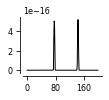

In [264]:
ge.plot(X[:,0])

In [263]:
X = sim.run_single_connectivity_sim(sim.ecMatrix)

In [201]:
sim.compute_exc_inh_matrices(sim.ecMatrix)

(array([[40., 40., 80., 40.],
        [ 1.,  1.,  1.,  1.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 5.,  1., 20., 20.],
        [ 4., 40., 20.,  4.]]), array([[  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [ 50., 100.,  50.,  10.],
        [  5.,   5.,  50.,   5.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.]]))

In [188]:
np.multiply(sim.ecMatrix, sim.CinhF)

array([[  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [ 50., 100.,  50.,  10.],
       [  5.,   5.,  50.,   5.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.]])

In [189]:
Cinh

array([[  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [ 50., 100.,  50.,  10.],
       [  5.,   5.,  50.,   5.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.]])

In [111]:
x1 = np.dot(np.concatenate([X[0,:], FAFF[int(0/dt),:]]), Cexc)
x2 = np.dot(np.concatenate([X[0,:], FAFF[int(0/dt),:]]), Cexc)
x3 = I_INTRINSINC[int(0/dt),:]
func(np.array([x1,x2,x3]).T)

array([4.04107991e-14, 8.21929403e-09, 5.81159384e-14, 3.77449615e-15])

In [193]:
REC_POPS = ['oscillExc', 'recInh']
AFF_POPS = ['AffExc']
# adding the same LIF props to all recurrent pops
LIF_props = {'Gl':10., 'Cm':200.,'Trefrac':5.,
             'El':-70, 'Vthre':-50., 'Vreset':-70., 'deltaV':0.,
             'a':0., 'b': 0., 'tauw':1e9}

In [194]:
Model = {
    'N_oscillExc':1000, 'N_recInh':1000, 'N_AffExc':100,
    'Tse':5., 'Tsi':5.,
    'Ee':0., 'Ei': -80.,
    'F_AffExc':2.}
Model['oscillExc_Ioscill_freq']=3.
Model['oscillExc_Ioscill_amp']= 10.*15.
# cellular features
for pop in REC_POPS:
    for key, val in LIF_props.items():
        Model['%s_%s' % (pop, key)] = val
for aff in REC_POPS+AFF_POPS:
    for target in REC_POPS:
        if len(aff.split('Exc'))>0:
            Model['Q_%s_%s' % (aff, target)] = 2.
        if len(aff.split('Inh'))>0:
            Model['Q_%s_%s' % (aff, target)] = 10.
        else:
            print('Interaction: %s -> %s not recognized as Exc or Inh !!' % (aff, target))
        # === initializing connectivity === #         
        Model['p_%s_%s' % (aff, target)] = 0. # zero connectivity by default
Model['p_AffExc_oscillExc'] = 0.1
Model['p_oscillExc_oscillExc'] = 0.

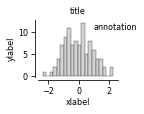

In [232]:
ge = graph_env()
fig, ax = ge.hist(np.random.randn(100),
                  axes_args=dict(xlabel='xlabel', ylabel='ylabel'))
ge.title(ax, 'title')
ge.annotate(ax, 'annotation', (.7,.8), xycoords='axes fraction')

In [222]:
func([20., 0., 0.])

array([6.80471688e-18])

(<Figure size 453.543x260.787 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa287fb2f50>)

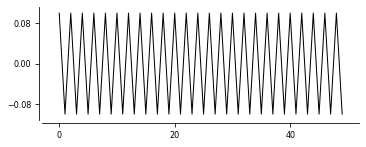

In [221]:
tstop, dt = 500e-3, 10e-3
tau=5e-3
t = np.arange(int(tstop/dt))*dt
Y = np.ones((len(t),len(REC_POPS)))*0.1

Connectivity_Matrix = None
# Connectivity matrix of size (a+f, f)
C = np.zeros((len(REC_POPS)+len(AFF_POPS), len(REC_POPS)))
Cexc, Cinh = 0*C, 0*C
# building the connectivities for the ODE solver
for i, ii in enumerate(REC_POPS+AFF_POPS):
    for j, jj in enumerate(REC_POPS):
        if Connectivity_Matrix is None:
            C[i,j] = Model['p_%s_%s' % (ii,jj)]*Model['N_%s' % ii]
        else:
            C[i,j] = Connectivity_Matrix[i,j]
        if len(ii.split('Exc'))>1:
            Cexc[i,j] = C[i,j]
        elif len(ii.split('Inh'))>1:
            Cinh[i,j] = C[i,j]
        else:
            print('/!\ %s is not classified as Exc or Inh' % ii+jj)

def Fexc_over_pops(X, t):
    return np.dot(np.concatenate([X, [Model['F_AffExc']]]), Cexc)

def Finh_over_pops(X, t):
    return np.dot(np.concatenate([X, [Model['F_AffExc']]]), Cinh)

def growth_factor(X, t):
    return np.array([func([Fexc_over_pops(X,t)[i],
                           Finh_over_pops(X,t)[i],
                           0*(1-np.cos(2*np.pi*3*t))])[0] for i in range(len(REC_POPS))])


for it, tt in enumerate(t[1:]):
    Fout = growth_factor(Y[it,:],tt)
    # print(Fout, dt*(Fout-Y[it,:])/tau)
    Y[it+1,:] = Y[it,:]+dt*(Fout-Y[it,:])/tau
    
ge.plot(Y[:,0], fig_args={'figsize':(2,2)}) 


(<Figure size 453.543x260.787 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa28c2521d0>)

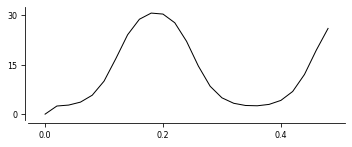

In [208]:
ge.plot(t, X['oscillExc'], fig_args={'figsize':(2,2)})

In [275]:
Model = {
    'N_Exc':1000, 'N_AffInh':1, 'N_AffExc':1,
    'Tse':5., 'Tsi':5.,
    'Ee':0., 'Ei': -80.,
    'F_AffExc':2., 'F_AffInh':2.}
# cellular features
for pop in REC_POPS:
    for key, val in LIF_props.items():
        Model['%s_%s' % (pop, key)] = val
for aff in REC_POPS+AFF_POPS:
    for target in REC_POPS:
        if len(aff.split('Exc'))>0:
            Model['Q_%s_%s' % (aff, target)] = 2.
        if len(aff.split('Inh'))>0:
            Model['Q_%s_%s' % (aff, target)] = 10.
        else:
            print('Interaction: %s -> %s not recognized as Exc or Inh !!' % (aff, target))
        # === initializing connectivity === #         
        Model['p_%s_%s' % (aff, target)] = 0. # zero connectivity by default
Model['p_AffExc_Exc'] = 1
Model['p_AffInh_Exc'] = 1

In [207]:
#from model import Model, REC_POPS, AFF_POPS
from analyz.processing.signanalysis import gaussian_smoothing as smooth

import neural_network_dynamics.main as ntwk

tstop, dt = 500e-3, 20e-3
t = np.arange(int(tstop/dt))*dt

DYN_SYSTEM, INPUTS = {}, {}
for rec in REC_POPS:
    Model['COEFFS_%s' % rec] = np.load('data/COEFFS_pyrExc.npy')
    # DYN_SYSTEM[rec] = {'aff_pops':['AffExc', 'NoiseExc'], 'x0':1e-1}
    DYN_SYSTEM[rec] = {'aff_pops':['AffExc'], 'x0':1e-1}
    # INPUTS['AffExc_%s' % rec] = smooth(np.array([4.*int(tt) for tt in t]), int(.2/dt))
    INPUTS['AffExc_%s' % rec] = Model['F_AffExc']+0*t
    # INPUTS['NoiseExc_%s' % rec] = 3+0*t

CURRENT_INPUTS = {'oscillExc':Model['oscillExc_Ioscill_amp']*(1-np.cos(Model['oscillExc_Ioscill_freq']*2*np.pi*t))/2.}

X = ntwk.mean_field.solve_mean_field_first_order(Model,
                                                 DYN_SYSTEM,
                                                 INPUTS=INPUTS,
                                                 CURRENT_INPUTS=CURRENT_INPUTS,
                                                 dt=dt, tstop=tstop)


2.6005583810190283
0.0
[500.11167620380564, -20.0]
2.6005583810190283
0.0
[500.08498164487065, -19.998932456081107]
2.6005583810190283
0.0
[500.0849830697514, -19.998932513063608]
2.6005583810190283
0.0
[500.058289935545, -19.99786502612113]
2.6005583810190283
0.0
[500.05829136034964, -19.997865083100592]
2.6005583810190283
0.0
[498.5301878659616, -19.93675459250027]
2.6005583810190283
0.0
[498.53018428209094, -19.93675444917746]
2.6005583810190283
0.0
[497.00675403879603, -19.875830846878912]
2.6005583810190283
0.0
[497.00674688198944, -19.875830560670575]
2.6005583810190283
0.0
[495.48797203051686, -19.815093132462497]
2.6005583810190283
0.0
[495.48796489557213, -19.81509284712844]
2.6005583810190283
0.0
[488.4561594157827, -19.533883436735717]
2.6005583810190283
0.0
[488.45609667497047, -19.53388092766363]
2.6005583810190283
0.0
[490.46216781417644, -19.61410585480125]
2.6005583810190283
0.0
[490.4621354677038, -19.61410456123126]
2.6005583810190283
0.0
[485.4872426466974, -19.41515

5.864710782795199
0.0
[424.06933559352086, -0.00012215729081709015]
5.864710782795199
0.0
[424.06933559347584, -0.00012215729081707714]
5.864710782795199
0.0
[423.0365172824806, -0.00012185977747152749]
5.864710782795199
0.0
[423.03651728220314, -0.00012185977747144757]
5.864710782795199
0.0
[422.0062143937175, -0.0001215629887177824]
5.864710782795199
0.0
[422.00621439370394, -0.00012156298871777848]
5.864710782795199
0.0
[420.9784208016943, -0.00012126692279133429]
5.864710782795199
0.0
[420.9784208016806, -0.00012126692279133032]
5.864710782795199
0.0
[410.8371590522981, -0.00011834563384918656]
5.864710782795199
0.0
[410.83715901484226, -0.00011834563383839732]
5.864710782795199
0.0
[400.9401977086676, -0.000115494718011642]
5.864710782795199
0.0
[400.9401976301307, -0.00011549471798902203]
5.864710782795199
0.0
[391.2816513658617, -0.0001127124799306519]
5.864710782795199
0.0
[391.28165149501626, -0.00011271247996785947]
5.864710782795199
0.0
[381.8557771894316, -0.000109997265326

0.0
[1225.2559464680367, -3.641726386748379e-08]
17.009423341468935
0.0
[1099.942680393788, -3.2692681840457154e-08]
17.009423341468935
0.0
[1099.9426974480673, -3.26926823473476e-08]
17.009423341468935
0.0
[987.4457814253752, -2.93490300378939e-08]
17.009423341468935
0.0
[987.445876760465, -2.934903287146245e-08]
17.009423341468935
0.0
[886.4547629000767, -2.6347357954206794e-08]
17.009423341468935
0.0
[886.4546733105541, -2.6347355291417416e-08]
17.009423341468935
0.0
[795.79252081775, -2.3652679505803247e-08]
17.009423341468935
0.0
[795.7923708414256, -2.365267504818367e-08]
17.009423341468935
0.0
[714.4026350802523, -2.123359559636482e-08]
17.009423341468935
0.0
[714.4025754360506, -2.1233593823609898e-08]
17.009423341468935
0.0
[641.3369872332996, -1.906192608930277e-08]
17.009423341468935
0.0
[641.3369322758559, -1.9061924455848404e-08]
17.009423341468935
0.0
[575.744136319624, -1.7112364312900408e-08]
17.009423341468935
0.0
[575.7440902699461, -1.711236294420407e-08]
17.00942334

30.363384139837393
0.0
[-61.697422124730394, -4.635754509073997e-15]
30.363384139837393
0.0
[-61.55438126748365, -4.635754448688891e-15]
30.363384139837393
0.0
[-61.69742197859165, -4.6357546063795075e-15]
30.363384139837393
0.0
[-61.52577316946903, -4.6357543877158505e-15]
30.706682415113868
0.0
[6.990134027713424, -4.654332261097851e-15]
30.706682415113868
0.0
[6.9901410248448315, -4.654336920089051e-15]
30.706682415113868
0.0
[6.9831508768274375, -4.6496825785130774e-15]
30.706682415113868
0.0
[6.983157866975631, -4.649687232854651e-15]
30.706682415113868
0.0
[6.96920551057616, -4.640397153115269e-15]
30.706682415113868
0.0
[6.969205496616837, -4.64039714382054e-15]
30.363384139837393
0.0
[-61.70437401727753, -4.631125639637416e-15]
30.363384139837393
0.0
[-61.63571439018014, -4.631125621052565e-15]
30.363384139837393
0.0
[-61.704387969647456, -4.631116349548388e-15]
30.363384139837393
0.0
[-61.56704078280626, -4.6311349111369204e-15]
30.706682415113868
0.0
[6.9687744402394, -4.6401

14.509945678992764
0.0
[-835.0014039042144, -1.5627632232565303e-20]
14.509945678992764
0.0
[-740.3367038389497, -1.3855916507168108e-20]
14.509945678992764
0.0
[-740.3363198962502, -1.3855909321413097e-20]
14.509945678992764
0.0
[-656.4036553249913, -1.2285051107180252e-20]
14.509945678992764
0.0
[-656.4035366720311, -1.2285048886507555e-20]
14.509945678992764
0.0
[-581.98642131131, -1.089228079626475e-20]
14.509945678992764
0.0
[-581.986302029734, -1.0892278563827049e-20]
14.509945678992764
0.0
[-516.005926014676, -9.657409920363093e-21]
14.509945678992764
0.0
[-516.00583734336, -9.657408260817724e-21]
14.509945678992764
0.0
[-445.2411907703258, -8.332998665169053e-21]
14.509945678992764
0.0
[-445.2410253498506, -8.33299556920978e-21]
14.509945678992764
0.0
[-384.1812140445725, -7.190218717809227e-21]
14.509945678992764
0.0
[-384.18086661963855, -7.190212215509855e-21]
14.509945678992764
0.0
[-331.49473809373757, -6.204154663377989e-21]
14.509945678992764
0.0
[-331.4944814415973, -6.

[-311.5632466569377, -1.6187409443258514e-25]
3.350067065525222
0.0
[-306.21405658040214, -1.5909489852652767e-25]
3.350067065525222
0.0
[-306.2140565834399, -1.5909489852810593e-25]
3.350067065525222
0.0
[-300.9567060764736, -1.5636341828593555e-25]
3.350067065525222
0.0
[-300.9567060794549, -1.5636341828748442e-25]
3.350067065525222
0.0
[-267.1960739765126, -1.3882292913232035e-25]
3.350067065525222
0.0
[-267.1960796288447, -1.388229320690061e-25]
3.350067065525222
0.0
[-237.22260691110435, -1.2325007870711246e-25]
3.350067065525222
0.0
[-237.22264063784095, -1.2325009622984345e-25]
3.350067065525222
0.0
[-210.61158253915747, -1.094242005963239e-25]
3.350067065525222
0.0
[-210.61154715100585, -1.0942418220992537e-25]
3.350067065525222
0.0
[-186.98569136330167, -9.714926194309211e-26]
3.350067065525222
0.0
[-186.98562804251216, -9.714922904437266e-26]
3.350067065525222
0.0
[-166.010040562586, -8.625126766756281e-26]
3.350067065525222
0.0
[-166.01001233474247, -8.625125300165314e-26]
3

3.056239915527065
0.0
[85.52358521562739, -1.0759142851048385e-30]
2.62665941249819
0.0
[-0.3390260436074044, -1.0765754748258205e-30]
2.62665941249819
0.0
[-0.33902604364444144, -1.0765754749435143e-30]
2.62665941249819
0.0
[-0.3390224988974566, -1.0765642186176286e-30]
2.62665941249819
0.0
[-0.33902249893449365, -1.0765642187353212e-30]
2.62665941249819
0.0
[-0.3390154095888498, -1.0765417065543163e-30]
2.62665941249819
0.0
[-0.3390083203914429, -1.076519194844068e-30]
2.62665941249819
0.0
[-0.339001231342273, -1.0764966836045626e-30]
2.62665941249819
0.0
[-0.3389303490034301, -1.076271597098592e-30]
2.62665941249819
0.0
[-0.33885948148526523, -1.0760465576556865e-30]
3.056239915527065
0.0
[85.5773119769898, -1.0758215652672736e-30]
3.056239915527065
0.0
[85.56982605171379, -1.0758215652672743e-30]
3.056239915527065
0.0
[85.57731197698936, -1.0758215652689138e-30]
3.056239915527065
0.0
[85.56832886665893, -1.0758215652664542e-30]
3.056239915527065
0.0
[85.57725529631135, -1.076001554

0.0
[549.5786177948121, -3.609601941657493e-34]
7.002852235354842
0.0
[549.5812012289967, -3.609601941495324e-34]
7.002852235354842
0.0
[549.5760343606273, -3.609601941819663e-34]
4.277456964164962
0.0
[4.502186898804794, -3.6096339376108237e-34]
4.277456964164962
0.0
[4.502184129804476, -3.6096317175613193e-34]
7.002852235354842
0.0
[549.5812328297849, -3.6096272774664078e-34]
7.002852235354842
0.0
[549.5808975871399, -3.6096272774664078e-34]
7.002852235354842
0.0
[549.5812328297815, -3.609627277463677e-34]
7.002852235354842
0.0
[549.5805623444985, -3.6096272774691387e-34]
4.277456964164962
0.0
[4.5021831323310835, -3.609630917835784e-34]
7.002852235354842
0.0
[549.5812363728324, -3.609630118109237e-34]
7.002852235354842
0.0
[549.5811156086061, -3.6096301181094142e-34]
4.277456964164962
0.0
[4.50218270900411, -3.6096305784328756e-34]
7.002852235354842
0.0
[549.5812365236529, -3.6096302390298544e-34]
7.002852235354842
0.0
[549.5811852714565, -3.6096302390298864e-34]
7.002852235354842
0

0.0
[700.7776925413339, -5.684941086794926e-38]
19.56287817827551
0.0
[700.7780737729057, -5.684944179471895e-38]
19.56287817827551
0.0
[620.8323231246652, -5.036397732557075e-38]
19.56287817827551
0.0
[620.8315601579087, -5.036391543117673e-38]
19.56287817827551
0.0
[550.0059471349197, -4.4618306777287066e-38]
19.56287817827551
0.0
[550.0056094491093, -4.4618279383094114e-38]
19.56287817827551
0.0
[487.25974482526124, -3.9528126719515273e-38]
19.56287817827551
0.0
[487.25964550047746, -3.9528118661959357e-38]
19.56287817827551
0.0
[431.67198969367246, -3.5018663641085145e-38]
19.56287817827551
0.0
[431.67188630686013, -3.501865525400398e-38]
19.56287817827551
0.0
[382.4257713461904, -3.102364706118212e-38]
19.56287817827551
0.0
[382.4257141830948, -3.102364242392228e-38]
19.56287817827551
0.0
[326.50669653474364, -2.6487306231349106e-38]
19.56287817827551
0.0
[326.5065217984393, -2.648729205616039e-38]
19.56287817827551
0.0
[278.76438031893184, -2.2614291180744916e-38]
19.562878178275

In [6]:
REC_POPS = ['Exc']
AFF_POPS = ['AffExc', 'AffInh']
Model = {
    'N_Exc':1, 'N_AffInh':10, 'N_AffExc':10,
    'Tse':5., 'Tsi':5.,
    'Ee':0., 'Ei': -80.,
    'F_AffExc':100., 'F_AffInh':10.}
LIF_props = {'Gl':10., 'Cm':200.,'Trefrac':5.,
             'El':-70, 'Vthre':-50., 'Vreset':-70., 'deltaV':0.,
             'a':0., 'b': 0., 'tauw':1e9}
# cellular features
for pop in REC_POPS:
    for key, val in LIF_props.items():
        Model['%s_%s' % (pop, key)] = val
for aff in REC_POPS+AFF_POPS:
    for target in REC_POPS:
        if len(aff.split('Exc'))>0:
            Model['Q_%s_%s' % (aff, target)] = 2.
        elif len(aff.split('Inh'))>0:
            Model['Q_%s_%s' % (aff, target)] = 10.
        else:
            print('Interaction: %s -> %s not recognized as Exc or Inh !!' % (aff, target))
        # === initializing connectivity === #         
        Model['p_%s_%s' % (aff, target)] = 0. # zero connectivity by default
Model['p_AffExc_Exc'] = 0.1
Model['p_AffInh_Exc'] = 0.1

In [8]:

REC_POPS = ['Exc']
AFF_POPS = ['AffExc', 'AffInh']
Model = {
    'N_Exc':1, 'N_AffInh':10, 'N_AffExc':10,
    'Tse':5., 'Tsi':5.,
    'Ee':0., 'Ei': -80.,
    'F_AffExc':100., 'F_AffInh':10.}
LIF_props = {'Gl':10., 'Cm':200.,'Trefrac':5.,
             'El':-70, 'Vthre':-50., 'Vreset':-70., 'deltaV':0.,
             'a':0., 'b': 0., 'tauw':1e9}
# cellular features
for pop in REC_POPS:
    for key, val in LIF_props.items():
        Model['%s_%s' % (pop, key)] = val
for aff in REC_POPS+AFF_POPS:
    for target in REC_POPS:
        if len(aff.split('Exc'))>0:
            Model['Q_%s_%s' % (aff, target)] = 2.
        elif len(aff.split('Inh'))>0:
            Model['Q_%s_%s' % (aff, target)] = 10.
        else:
            print('Interaction: %s -> %s not recognized as Exc or Inh !!' % (aff, target))
        # === initializing connectivity === #         
        Model['p_%s_%s' % (aff, target)] = 0. # zero connectivity by default
Model['p_AffExc_Exc'] = 0.1
Model['p_AffInh_Exc'] = 0.1

import itertools

# mean field formalism
nrn_params = ntwk.built_up_neuron_params(Model, 'Exc')
syn_input = ntwk.build_up_afferent_synaptic_input(Model,
                                                  ['AffExc', 'AffInh'], 'Exc')
Model['COEFFS'] = np.load('data/COEFFS_pyrExc.npy')
# now approx
# scanning grid !
N = 100
Freq_Exc = np.logspace(-2, 3, N+1)
Freq_Inh = np.logspace(-2, 3, N)
Ioscill = np.linspace(0, 20*10, N-1)
output_freq = np.zeros((len(Freq_Exc), len(Freq_Inh), len(Ioscill)))
for i, j, k in itertools.product(range(len(Freq_Exc)), range(len(Freq_Inh)), range(len(Ioscill))):
    if Freq_Exc[i]<10:
        output_freq[i,j,k] = 0
    else:
        output_freq[i,j,k] = ntwk.mean_field.input_output(nrn_params, syn_input,
                                {'F_AffExc':Freq_Exc[i], 'F_AffInh':Freq_Inh[j]},
                                Model['COEFFS'],
                                current_input=Ioscill[k])
from scipy.interpolate import RegularGridInterpolator
func = RegularGridInterpolator([Freq_Exc*Model['p_AffExc_Exc']*Model['N_AffExc'],
                                Freq_Inh*Model['p_AffInh_Exc']*Model['N_AffInh'],
                                Ioscill],
                               output_freq,
                               method='linear',
                               fill_value=None, bounds_error=False)


In [9]:
I = 100
print(ntwk.mean_field.input_output(nrn_params, syn_input,
                                   {'F_AffExc': 100, 'F_AffInh': 10},
                                   Model['COEFFS'],
                                   current_input=I))
print(func([100, 10, 100])[0])

1.8959134784366254
1.896078166317099


In [23]:
dt, tstop = 1e-2, 3.
t = np.arange(int(tstop/dt))*dt

DYN_SYSTEM, INPUTS = {}, {}
for rec in REC_POPS:
    Model['COEFFS_%s' % rec] = np.load('data/COEFFS_pyrExc.npy')
    # DYN_SYSTEM[rec] = {'aff_pops':['AffExc', 'NoiseExc'], 'x0':1e-1}
    DYN_SYSTEM[rec] = {'aff_pops':['AffExc', 'AffInh'], 'x0':1e-1}
    # INPUTS['AffExc_%s' % rec] = smooth(np.array([4.*int(tt) for tt in t]), int(.2/dt))
    INPUTS['AffExc_%s' % rec] = Model['F_AffExc']+0*t
    INPUTS['AffInh_%s' % rec] = Model['F_AffInh']+0*t
    # INPUTS['NoiseExc_%s' % rec] = 3+0*t

CURRENT_INPUTS = {'Exc':100*(1-np.cos(3.*2*np.pi*t))/2.}

X = ntwk.mean_field.solve_mean_field_first_order(Model,
                                                 DYN_SYSTEM,
                                                 INPUTS=INPUTS,
                                                 CURRENT_INPUTS=CURRENT_INPUTS,
                                                 dt=dt, tstop=tstop)


running ODE integration [...]
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00042228860591863985
0.00

0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.08660475669779
0.19628937825301274
0.19628937825301274
0.196289

0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.50137529838557
0.50137529838557
0.50137529838557
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.50137529838557
0.50137529838557
0.50137529838557
0.50137529838557
0.50137529838557
0.50137529838557
0.50137529838557
0.50137529838557
0.8683567076035998
0.50137529838557
0.50137529838557
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.50137529838557
0.50137529838557
0.86

0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.00404673858

0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.027159447931530963
0.06504995443

1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.7701978190044623
1.7701978190044623
1.7701978190044623
1.7701978190044623
1.7701978190044623
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.7701978190044623
1.7701978190044623
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784366254
1.8959134784

0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.001409884847556723
0.001409884847556723
0.001409884847556723
0.0025549641849196784
0.0025549641849196784
0.0025549641849196784
0.00255496418

0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.004046738584153179
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.008751566564971473
0.00875156656

1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.6777055556299882
1.6777055556299882
1.6777055556299882
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.2987537149885329
1.6777055556299882
1.6777055556299882
1.6777055556299882
1.6777055556299882
1.6777055556299882
1.6777055556

0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.01526064932

0.0006860264400044822
0.0006860264400044822
0.0006860264400044822
0.0006860264400044822
0.0006860264400044822
0.0006860264400044822
0.0006860264400044822
0.0006860264400044822
0.0006860264400044822
0.0006860264400044822
0.0006860264400044822
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0006860264400044822
0.0006860264400044822
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0006860264400044822
0.0006860264400044822
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.00101465

1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.1545183907837184
1.1545183907837184
1.1545183907

0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.1146637551674983
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997

0.011518308272011677
0.005181365399350836
0.005181365399350836
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.011518308272011677
0.01151830827

1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.7701978190044623
1.7701978190044623
1.7701978190044623
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.7701978190044623
1.7701978190044623
1.7701978190044623
1.7701978190044623
1.7701978190044623
1.7701978190044623
1.7701978190044623
1.7701978190044623
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175

0.002554964184919683
0.002554964184919683
0.002554964184919683
0.002554964184919683
0.002554964184919683
0.002554964184919683
0.005181365399350822
0.005181365399350822
0.005181365399350822
0.005181365399350822
0.005181365399350822
0.005181365399350822
0.005181365399350822
0.005181365399350822
0.002554964184919683
0.002554964184919683
0.002554964184919683
0.002554964184919683
0.005181365399350822
0.005181365399350822
0.005181365399350822
0.005181365399350822
0.005181365399350822
0.005181365399350822
0.002554964184919683
0.002554964184919683
0.002554964184919683
0.002554964184919683
0.005181365399350822
0.005181365399350822
0.005181365399350822
0.005181365399350822
0.005181365399350822
0.005181365399350822
0.002554964184919683
0.002554964184919683
0.002554964184919683
0.002554964184919683
0.005181365399350822
0.005181365399350822
0.005181365399350822
0.005181365399350822
0.005181365399350822
0.005181365399350822
0.002554964184919683
0.002554964184919683
0.002554964184919683
0.00255496418

0.008751566564971475
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.0203228807201021
0.04867899

1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.5652915029395313
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.5652915029395313
1.5652915029

0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.006702857925873605
0.006702857925873605
0.006702857925873605
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.006702857925873605
0.006702857925873605
0.006702857925873605
0.006702857925873605
0.006702857925873605
0.006702857925873605
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.006702857925873605
0.006702857925873605
0.006702857925873605
0.006702857925873605
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.006702857925873605
0.006702857925873605
0.006702857925873605
0.006702857925873605
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.015260649323422653
0.006702857925873605
0.006702857925873605
0.006702857925873605
0.006702857925873605
0.01526064932

0.0016962305365116755
0.0016962305365116755
0.0016962305365116755
0.0016962305365116755
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0016962305365116755
0.0016962305365116755
0.0016962305365116755
0.0016962305365116755
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0016962305365116755
0.0016962305365116755
0.0016962305365116755
0.0016962305365116755
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0016962305365116755
0.0016962305365116755
0.0016962305365116755
0.0016962305365116755
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0010146524112493263
0.0016962305365116755
0.0016962305365116755
0.0016962305365116755
0.0016962305365116755
0.0016962305365116755
0.0016962305365116755
0.0016962305365116755
0.0016962305365116755
0.0016962305365116755
0.00169623

0.7347566008977299
0.7347566008977299
0.40475106575629716
0.7347566008977299
0.7347566008977299
0.40475106575629716
0.7347566008977299
0.7347566008977299
0.40475106575629716
0.40475106575629716
0.40475106575629716
0.40475106575629716
0.40475106575629716
0.40475106575629716
0.40475106575629716
0.40475106575629716
0.40475106575629716
0.7347566008977299
0.7347566008977299
0.40475106575629716
0.40475106575629716
0.40475106575629716
0.7347566008977299
0.7347566008977299
0.7347566008977299
0.7347566008977299
0.7347566008977299
0.7347566008977299
0.40475106575629716
0.40475106575629716
0.40475106575629716
0.40475106575629716
0.40475106575629716
0.40475106575629716
0.40475106575629716
0.7347566008977299
0.7347566008977299
0.7347566008977299
0.7347566008977299
0.7347566008977299
0.7347566008977299
0.7347566008977299
0.7347566008977299
0.7347566008977299
0.7347566008977299
0.7347566008977299
0.7347566008977299
0.7347566008977299
0.7347566008977299
0.7347566008977299
0.7347566008977299
0.73475660

0.8683567076035998
0.5013752983855672
0.5013752983855672
0.5013752983855672
0.5013752983855672
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.5013752983855672
0.5013752983855672
0.5013752983855672
0.5013752983855672
0.5013752983855672
0.5013752983855672
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.5013752983855672
0.5013752983855672
0.5013752983855672
0.5013752983855672
0.5013752983855672
0.5013752983855672
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.8683567076035998
0.5013752983855672
0.5013752983855672
0.5013752983855672
0.5013752983855672
0.5013752983855672
0.5013752983855672
0.5013752983855672
0.5013752983855672
0.5013752983855672
0.5013752983

0.0007711688542144932
0.0007711688542144932
0.0007711688542144932
0.0007711688542144932
0.0007711688542144932
0.0007711688542144932
0.0007711688542144932
0.0011879052316421577
0.0011879052316421577
0.0007711688542144932
0.0007711688542144932
0.0007711688542144932
0.0007711688542144932
0.0007711688542144932
0.0007711688542144932
0.0011879052316421577
0.0011879052316421577
0.0011879052316421577
0.0011879052316421577
0.0011879052316421577
0.0011879052316421577
0.0011879052316421577
0.0011879052316421577
0.0011879052316421577
0.0011879052316421577
0.0011879052316421577
0.0011879052316421577
0.0011879052316421577
0.0007711688542144932
0.0007711688542144932
0.0007711688542144932
0.0007711688542144932
0.0011879052316421577
0.0011879052316421577
0.0011879052316421577
0.0011879052316421577
0.0007711688542144932
0.0007711688542144932
0.0007711688542144932
0.0007711688542144932
0.0007711688542144932
0.0007711688542144932
0.0007711688542144932
0.0007711688542144932
0.0007711688542144932
0.00077116

0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480519455
0.3221103480

1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.0095549740338905
1.0095549740338905
1.0095549740338905
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.0095549740338905
1.0095549740338905
1.0095549740338905
1.0095549740338905
1.0095549740338905
1.0095549740338905
1.437355096264175
1.437355096264175
1.437355096264175
1.437355096264175
1.0095549740338905
1.0095549740338905
1.0095549740338905
1.0095549740338905
1.437355096264175
1.437355096264175
1.4373550962641

0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0004892120561018513
0.0004892120561018513
0.0004892120561018513
0.0004892120561018513
0.0004892120561018513
0.0004892120561018513
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0006184058111108288
0.0004892120561018513
0.0004892120561018513
0.0004892120561018513
0.0004892120561018513
0.0006184058111108288
0.0006184058111108288
0.0004892120561018513
0.0004892120561018513
0.0004892120561018513
0.00048921

0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.1146637551674974
0.1146637551674974
0.1146637551674974
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.048678997466362055
0.1146637551674974
0.1146637551674974
0.1146637551674974
0.1146637551674974
0.1146

0.7347566008977389
0.7347566008977389
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
0.7347566008977389
0.7347566008977389
0.7347566008977389
0.7347566008977389
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
0.7347566008977389
0.7347566008977389
0.7347566008977389
0.7347566008977389
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
0.7347566008977389
0.7347566008977389
0.7347566008977389
0.7347566008977389
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
1.1545183907837184
0.7347566008977389
0.7347566008977389
0.7347566008977389
0.7347566008977389
0.7347566008977389
0.7347566008977389
1.1545183907837184
1.1545183907837184
0.7347566008977389
0.7347566008977389
0.7347566008977389
0.7347566008977389
0.7347566008977389
0.7347566008977389
0.7347566008977389
0.7347566008977389
0.7347566008977389
0.7347566008

0.0005223452420844631
0.0005223452420844631
0.0005223452420844631
0.0005223452420844631
0.0005223452420844631
0.0005223452420844631
0.0005223452420844631
0.0005223452420844631
0.0005223452420844631
0.0005223452420844631
0.0005223452420844631
0.0004451193229830507
0.0004451193229830507
0.0004451193229830507
0.0004451193229830507
0.0004451193229830507
0.0004451193229830507
0.0005223452420844631
0.0005223452420844631
0.0004451193229830507
0.0004451193229830507
0.0004451193229830507
0.0004451193229830507
0.0005223452420844631
0.0005223452420844631
0.0005223452420844631
0.0005223452420844631
0.0004451193229830507
0.0004451193229830507
0.0004451193229830507
0.0004451193229830507
0.0005223452420844631
0.0005223452420844631
0.0005223452420844631
0.0005223452420844631
0.0005223452420844631
0.0005223452420844631
0.0005223452420844631
0.0005223452420844631
0.0004451193229830507
0.0004451193229830507
0.0004451193229830507
0.0004451193229830507
0.0005223452420844631
0.0005223452420844631
0.00052234

(<Figure size 918.425x260.787 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f40e0267c10>)

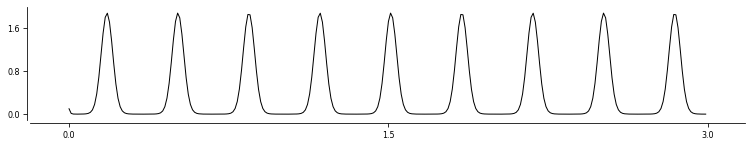

In [24]:
ge.plot(t, X['Exc'], fig_args={'figsize':(3,2)})

Adding Increasing Step Waveform to: AffExc
Setting Constant Level to: NoiseExc
Adding intrinsic oscillation to: oscillExc
Initializing simulation [...]
Performing grid simulation [...]
Building interpolation [...]
--> Done !
Euler comput. took 197.3 micro-sec


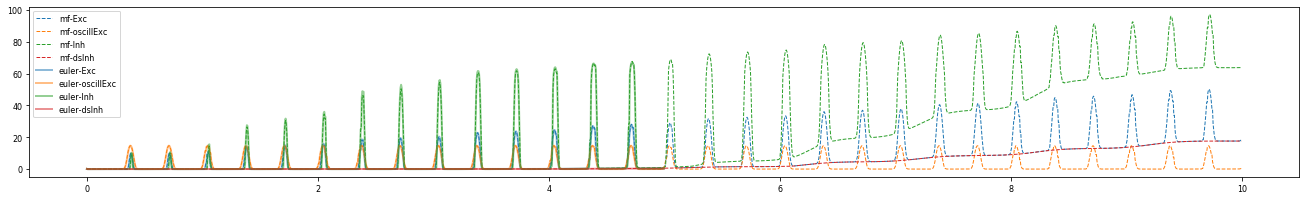

In [279]:
REC_POPS = ['Exc', 'oscillExc', 'Inh', 'dsInh']
AFF_POPS = ['AffExc', 'NoiseExc']
Model = {
    'N_Exc':1000, 'N_oscillExc':200, 'N_Inh':800, 'N_dsInh':800,
    'N_NoiseExc':100, 'N_AffExc':100,
    'Tse':5., 'Tsi':5.,
    'Ee':0., 'Ei': -80.,
    'F_AffExc':10., 'F_NoiseExc':5.,
    'tstop':10., 'dt':5e-3}
LIF_props = {'Gl':10., 'Cm':200.,'Trefrac':5.,
             'El':-70, 'Vthre':-50., 'Vreset':-70., 'deltaV':0.,
             'a':0., 'b': 0., 'tauw':1e9}

Model['oscillExc_Ioscill_freq']=3.
Model['oscillExc_Ioscill_amp']= 10.*15.
Model['oscillExc_Ioscill_onset']= .2 # 200ms delay for onset

Model['AffExc_IncreasingStep_t0']= 1.2 # 200ms delay for onset
Model['AffExc_IncreasingStep_baseline']= 0.
Model['AffExc_IncreasingStep_length']= 1.
Model['AffExc_IncreasingStep_size']= 4.
Model['AffExc_IncreasingStep_smoothing']= .2

dt, tstop = 5e-3, 5
t = np.arange(int(tstop/dt))*dt

Ioscill = Intrinsic_Oscill(t, 'oscillExc', Model)
F_AffExc = IncreasingSteps(t, 'AffExc', Model)
F_NoiseExc = Model['F_NoiseExc']+0*t

# cellular features
for pop in REC_POPS:
    for key, val in LIF_props.items():
        Model['%s_%s' % (pop, key)] = val
for aff in REC_POPS+AFF_POPS:
    for target in REC_POPS:
        if len(aff.split('Exc'))>0:
            Model['Q_%s_%s' % (aff, target)] = 2.
        elif len(aff.split('Inh'))>0:
            Model['Q_%s_%s' % (aff, target)] = 10.
        else:
            print('Interaction: %s -> %s not recognized as Exc or Inh !!' % (aff, target))
        # === initializing connectivity === #         
        Model['p_%s_%s' % (aff, target)] = 0. # zero connectivity by default
        
#
Model['p_AffExc_Exc'] = 0.1
Model['p_AffExc_Inh'] = 0.1
Model['p_AffExc_dsInh'] = 0.1
# 
Model['p_NoiseExc_Exc'] = 0.05
Model['p_NoiseExc_Inh'] = 0.05
Model['p_NoiseExc_dsInh'] = 0.05
Model['p_NoiseExc_oscillExc'] = 0.1
#
Model['p_oscillExc_Exc'] = 0.1
#
# Model['p_Exc_Exc'] = 0.03
Model['p_Exc_Inh'] = 0.03
# Model['p_Exc_dsInh'] = 0.03
#
# Model['p_Inh_Exc'] = 0.03
# Model['p_Inh_Inh'] = 0.03
# Model['p_Inh_dsInh'] = 0.03

DYN_SYSTEM, INPUTS = {}, {}
for rec in REC_POPS:
    Model['COEFFS_%s' % rec] = np.load('data/COEFFS_pyrExc.npy')
    # DYN_SYSTEM[rec] = {'aff_pops':['AffExc', 'NoiseExc'], 'x0':1e-1}
    DYN_SYSTEM[rec] = {'aff_pops':['AffExc', 'NoiseExc'], 'x0':1e-1}
    # INPUTS['AffExc_%s' % rec] = smooth(np.array([4.*int(tt) for tt in t]), int(.2/dt))
    INPUTS['AffExc_%s' % rec] = F_AffExc
    INPUTS['NoiseExc_%s' % rec] = F_NoiseExc

CURRENT_INPUTS = {'oscillExc':Ioscill}

Connectivity_Matrix = None
# Connectivity matrix of size (a+f, f)
C = np.zeros((len(REC_POPS)+len(AFF_POPS), len(REC_POPS)))
# connectivity matrix of excitatory interactions
Cexc = np.zeros((len(REC_POPS)+len(AFF_POPS), len(REC_POPS)))
# connectivity matrix of excitatory interactions
Cinh = np.zeros((len(REC_POPS)+len(AFF_POPS), len(REC_POPS)))
# building the connectivities for the ODE solver
for i, ii in enumerate(REC_POPS+AFF_POPS):
    for j, jj in enumerate(REC_POPS):
        if Connectivity_Matrix is None:
            C[i,j] = Model['p_%s_%s' % (ii,jj)]*Model['N_%s' % ii]
        else:
            C[i,j] = Connectivity_Matrix[i,j]
        if len(ii.split('Exc'))>1:
            Cexc[i,j] = C[i,j]
        elif len(ii.split('Inh'))>1:
            Cinh[i,j] = C[i,j]
        else:
            print('/!\ %s is not classified as Exc or Inh' % ii+jj)

FAFF = np.zeros((len(t),2))
FAFF[:,0] = F_AffExc
FAFF[:,1] = F_NoiseExc
I_INTRINSINC = np.zeros((len(t),len(REC_POPS)))
I_INTRINSINC[:,np.argwhere(np.array(REC_POPS)=='oscillExc')[0][0]] = Ioscill

def func2(x1, x2, x3):
    return func(np.array([x1, x2, x3]).T)

def growth_factor(X, t, Cexc=Cexc, Cinh=Cinh):
    Fexc_over_pops = np.dot(np.concatenate([X, FAFF[int(t/dt),:]]), Cexc)
    Finh_over_pops = np.dot(np.concatenate([X, FAFF[int(t/dt),:]]), Cinh)
    return func(np.array([Fexc_over_pops,
                          Finh_over_pops,
                          I_INTRINSINC[int(t/dt),:]]).T)
    
def dX_dt(X, t, Cexc=Cexc, Cinh=Cinh, tau=5e-3):
    return (growth_factor(X,t)-X)/tau

def Euler(dX_dt, X, t, dt, Cexc=Cexc, Cinh=Cinh):
    for it, tt in enumerate(t[:-1]):
        X[it+1,:] = X[it,:]+dt*dX_dt(X[it,:], tt)
    return X

sim = FastMeanField(Model, REC_POPS, AFF_POPS)
sim.build_TF_func(Ngrid=40)
X = sim.run_single_connectivity_sim(sim.ecMatrix)

fig, ax=ge.figure(figsize=(4,3))

for i, pop in enumerate(REC_POPS):
    ax.plot(sim.t, X[:,i], '--', lw=1, label='mf-%s' % pop, color=ge.colors[i])

# X = ntwk.mean_field.solve_mean_field_first_order(Model,
#                                                  DYN_SYSTEM,
#                                                  INPUTS=INPUTS,
#                                                  CURRENT_INPUTS=CURRENT_INPUTS,
#                                                  dt=dt, tstop=tstop, verbose=True)
# for i, pop in enumerate(REC_POPS):
#     ax.plot(t, X[pop], '--', lw=1, label='mf-%s' % pop, color=ge.colors[i])

start_time = time.time()
X = Euler(dX_dt, np.ones((len(t), len(REC_POPS)))*0.1, t, dt)
print('Euler comput. took %.1f micro-sec' % (1e3*time.time() - 1e3*start_time))
for i, pop in enumerate(REC_POPS):
    ax.plot(t, X[:,i], lw=2, label='euler-%s' % pop, color=ge.colors[i], alpha=.5)
ax.legend()


In [282]:
%timeit
X = sim.run_single_connectivity_sim(sim.ecMatrix)

In [47]:
X = Euler(dX_dt, X, t, dt)
ge.plot(t, X[:,0], ax=ax, lw=2, label='euler', color=ge.colors[1])


TypeError: unhashable type: 'slice'

running ODE integration [...]
--- ODE integration took 3.5 seconds ---
--- ODE integration took 2.1 seconds ---
--- ODE integration took 0.0 seconds ---
--- ODE integration took 0.0 seconds ---
--- ODE integration took 0.0 seconds ---
--- ODE integration took 0.0 seconds ---
--- ODE integration took 0.0 seconds ---


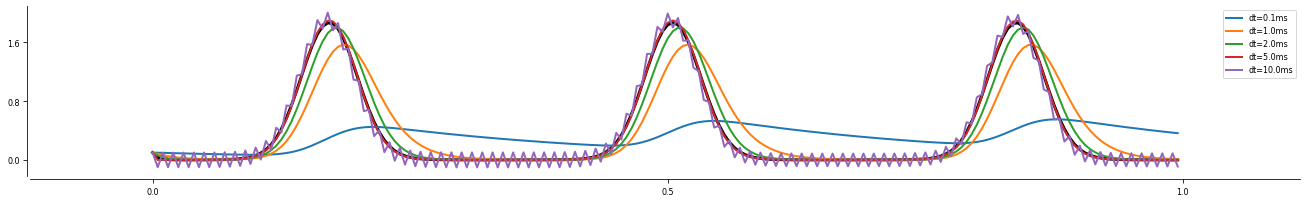

In [2]:
REC_POPS = ['Exc']
AFF_POPS = ['AffExc', 'AffInh']
Model = {
    'N_Exc':1, 'N_AffInh':10, 'N_AffExc':10,
    'Tse':5., 'Tsi':5.,
    'Ee':0., 'Ei': -80.,
    'F_AffExc':100., 'F_AffInh':10.}
LIF_props = {'Gl':10., 'Cm':200.,'Trefrac':5.,
             'El':-70, 'Vthre':-50., 'Vreset':-70., 'deltaV':0.,
             'a':0., 'b': 0., 'tauw':1e9}
# cellular features
for pop in REC_POPS:
    for key, val in LIF_props.items():
        Model['%s_%s' % (pop, key)] = val
for aff in REC_POPS+AFF_POPS:
    for target in REC_POPS:
        if len(aff.split('Exc'))>0:
            Model['Q_%s_%s' % (aff, target)] = 2.
        elif len(aff.split('Inh'))>0:
            Model['Q_%s_%s' % (aff, target)] = 10.
        else:
            print('Interaction: %s -> %s not recognized as Exc or Inh !!' % (aff, target))
        # === initializing connectivity === #         
        Model['p_%s_%s' % (aff, target)] = 0. # zero connectivity by default
Model['p_AffExc_Exc'] = 0.1
Model['p_AffInh_Exc'] = 0.1

import itertools

# mean field formalism
nrn_params = ntwk.built_up_neuron_params(Model, 'Exc')
syn_input = ntwk.build_up_afferent_synaptic_input(Model,
                                                  ['AffExc', 'AffInh'], 'Exc')
Model['COEFFS'] = np.load('data/COEFFS_pyrExc.npy')
# now approx
# scanning grid !
N = 100
Freq_Exc = np.logspace(-2, 3, N+1)
Freq_Inh = np.logspace(-2, 3, N)
Ioscill = np.linspace(0, 20*10, N-1)
output_freq = np.zeros((len(Freq_Exc), len(Freq_Inh), len(Ioscill)))
for i, j, k in itertools.product(range(len(Freq_Exc)), range(len(Freq_Inh)), range(len(Ioscill))):
    if Freq_Exc[i]<10:
        output_freq[i,j,k] = 0
    else:
        output_freq[i,j,k] = ntwk.mean_field.input_output(nrn_params, syn_input,
                                {'F_AffExc':Freq_Exc[i], 'F_AffInh':Freq_Inh[j]},
                                Model['COEFFS'],
                                current_input=Ioscill[k])
from scipy.interpolate import RegularGridInterpolator
func = RegularGridInterpolator([Freq_Exc*Model['p_AffExc_Exc']*Model['N_AffExc'],
                                Freq_Inh*Model['p_AffInh_Exc']*Model['N_AffInh'],
                                Ioscill],
                               output_freq,
                               method='linear',
                               fill_value=None, bounds_error=False)


dt, tstop = 1e-2, 3.
t = np.arange(int(tstop/dt))*dt

DYN_SYSTEM, INPUTS = {}, {}
for rec in REC_POPS:
    Model['COEFFS_%s' % rec] = np.load('data/COEFFS_pyrExc.npy')
    # DYN_SYSTEM[rec] = {'aff_pops':['AffExc', 'NoiseExc'], 'x0':1e-1}
    DYN_SYSTEM[rec] = {'aff_pops':['AffExc', 'AffInh'], 'x0':1e-1}
    # INPUTS['AffExc_%s' % rec] = smooth(np.array([4.*int(tt) for tt in t]), int(.2/dt))
    INPUTS['AffExc_%s' % rec] = Model['F_AffExc']+0*t
    INPUTS['AffInh_%s' % rec] = Model['F_AffInh']+0*t
    # INPUTS['NoiseExc_%s' % rec] = 3+0*t

CURRENT_INPUTS = {'Exc':100*(1-np.cos(3.*2*np.pi*t))/2.}

X = ntwk.mean_field.solve_mean_field_first_order(Model,
                                                 DYN_SYSTEM,
                                                 INPUTS=INPUTS,
                                                 CURRENT_INPUTS=CURRENT_INPUTS,
                                                 dt=dt, tstop=tstop)



Connectivity_Matrix = None
# Connectivity matrix of size (a+f, f)
C = np.zeros((len(REC_POPS)+len(AFF_POPS), len(REC_POPS)))
# connectivity matrix of excitatory interactions
Cexc = np.zeros((len(REC_POPS)+len(AFF_POPS), len(REC_POPS)))
# connectivity matrix of excitatory interactions
Cinh = np.zeros((len(REC_POPS)+len(AFF_POPS), len(REC_POPS)))
# building the connectivities for the ODE solver
for i, ii in enumerate(REC_POPS+AFF_POPS):
    for j, jj in enumerate(REC_POPS):
        if Connectivity_Matrix is None:
            C[i,j] = Model['p_%s_%s' % (ii,jj)]*Model['N_%s' % ii]
        else:
            C[i,j] = Connectivity_Matrix[i,j]
        if len(ii.split('Exc'))>1:
            Cexc[i,j] = C[i,j]
        elif len(ii.split('Inh'))>1:
            Cinh[i,j] = C[i,j]
        else:
            print('/!\ %s is not classified as Exc or Inh' % ii+jj)

from scipy.integrate import odeint

# building the non-synaptic currents
def func_Iintrinsic(tt):
    return [100*(1-np.cos(3.*2*np.pi*tt))/2.]

def growth_factor(X, t):
    
    Fexc_over_pops = np.dot(np.concatenate([X, [Model['F_AffExc'], Model['F_AffInh']]]),
                            Cexc)
    Finh_over_pops = np.dot(np.concatenate([X, [Model['F_AffExc'], Model['F_AffInh']]]),
                            Cinh)

    return np.array([func([Fexc_over_pops[i],
                           Finh_over_pops[i],
                           func_Iintrinsic(t)[i]])[0] for i in range(len(REC_POPS))])
    
def dX_dt(X, t, tau=5e-3):
    
    return (growth_factor(X,t)-X)/tau

def Euler(dX_dt, X, t, dt):
    for it, tt in enumerate(t[:-1]):
        X[it+1,:] = X[it,:]+dt*dX_dt(X[it,:], tt)
    return X

def ODErun(dX_dt, X, t, dt,
           method=''):

    start_time = time.time()
    if method is 'euler':
        X = Euler(dX_dt, X, t, dt)
    else:
        X = odeint(dX_dt, X[0,:], t)
    print("--- ODE integration took %.1f seconds ---" % (time.time() - start_time))
    return X

fig, ax=ge.figure(figsize=(4,3))

dt, tstop = 5e-3, 1
t = np.arange(int(tstop/dt))*dt
# ODE int
X = np.ones((len(t), len(REC_POPS)))*0.1
X = ODErun(dX_dt, X, t, dt)
ge.plot(t, X[:,0], ax=ax, lw=3, color='k')
# Euler
for i, dt in enumerate([1e-4, 1e-3, 2e-3, 5e-3, 10e-3]):
    X = ODErun(dX_dt, X, t, dt, method='euler')
    ge.plot(t, X[:,0], ax=ax, lw=2, color=ge.colors[i], label='dt=%.1fms' % (1e3*dt))
ax.legend()
